# GravNet for top-tagging

The data we will use for these examples are the constituents of jets, large collections particles which have been clustered together by some combination algorithm (such at [anti-k<sub>t</sub>](https://arxiv.org/abs/0802.1189)). Jets can be produced in particle collisions due to multiple reasons, such as the emission of an energetic light-quark or gluon (QCD) and the decay of some heavy particle (e.g. a *top* quark). Our data contains simulations for jets produced by both QCD interactions and hadronic top-quark decays, and our task is to learn to classify the production mechanism of each jet (either QCD - target 0, or top - target 1).

For each jet we have up to the first 200 jet constituents (our objects), which have been ordered by decreasing transverse momentum (*p<sub>t</sub>*), and we are provided with the Cartesian 4-momenta for each constituent: *p<sub>x</sub>*, *p<sub>y</sub>*, *p<sub>z</sub>*, and *E*.

This dataset is available from here https://desycloud.desy.de/index.php/s/llbX3zpLhazgPJ6, or by running the cell below. Warning, the dataset is quite large ~1.6 GB. A discussion of the dataset is documented here: https://docs.google.com/document/d/1Hcuc6LBxZNX16zjEGeq16DAzspkDC4nDTyjMp1bWHRo/edit, and the reference is "Deep-learned Top Tagging with a Lorentz Layer" by A Butter, G Kasieczka, T and M Russell ([arXiv: 1707.08966](https://arxiv.org/abs/1707.08966))

For the purpose of this tutorial, to save time and bandwidth (24MB versus >1GB), I've shared a preprocessed subsample of this dataset. The link to which becomes invalid on 18/07/21 to encourage the use of the official source.

In [1]:
import os
if 'google.colab' in str(get_ipython()):
    os.system('pip install lumin==0.8.0')

## Basic Modules

In [2]:
from typing import *
from functools import partial
from fastcore.all import Path

In [3]:
PATH = Path('./data')
PATH.mkdir(parents=True, exist_ok=True)

In [4]:
SCRATCH = False  # Whether to import data from scratch

# Importing data

In [5]:
if SCRATCH:
    import h5py
    import pandas as pd
    import numpy as np

    os.system("wget -O data.zip https://desycloud.desy.de/index.php/s/llbX3zpLhazgPJ6/download?path=%2F&files=train.h5")
    os.system("unzip data.zip")
    os.system("rm data.zip")
    LOAD = Path('./data')

#     LOAD = Path('../lumin/examples/data/top/')
    
    trn_store = pd.HDFStore(LOAD/'train.h5')

    def load_df(store:pd.io.pytables.HDFStore, n_evts:Optional[int]=None, n_const:Optional[int]=None) -> pd.DataFrame:
        df = trn_store.select("table",stop=n_evts).drop(columns=['truthE','truthPX','truthPY','truthPZ','ttv'])
        if n_const is not None: df.drop(columns=[f for f in df.columns if f != 'is_signal_new' and int(f[f.find('_')+1:]) >= n_const], inplace=True)
        rename = {f:f'{f[f.find("_")+1:]}_{f[:f.find("_")].lower()}' for f in df.columns if f != 'is_signal_new'}
        rename['is_signal_new'] = 'gen_target'
        df.rename(columns=rename, inplace=True)
        return df

    df = load_df(trn_store, 100000, 15)
    train_feats = [f for f in df.columns if f != 'gen_target']

    from lumin.data_processing.pre_proc import fit_input_pipe
    from lumin.data_processing.hep_proc import to_pt_eta_phi, proc_event, get_vecs

    def proc_df(df:pd.DataFrame, train_feats:List[str], preproc:bool=True) -> None:
        print('Moving to float32')
        df[train_feats] = df[train_feats].values.astype('float32')
        print('Replacing zeros')
        df[train_feats] = df[train_feats].replace(0.0, np.nan)  # Don't bias preprocessing with non-existent tracks
        print('Converting vectors')
        for v in get_vecs(train_feats): to_pt_eta_phi(df, v, True)    
        print('Processing event')
        proc_event(df, fix_phi=True, fix_y=True, fix_z=True, ref_vec_0='0', ref_vec_1='1', use_cartesian=True)
        print('Readding 0_py')
        df['0_py'] = 0.
        if preproc:
            print('Preprocessing features')
            print('Fitting preproc pipe')
            input_pipe = fit_input_pipe(df, train_feats, PATH/'input_pipe')
            print('Transforming features')
            df[train_feats] = input_pipe.transform(df[train_feats])  # Rescale and shift track momenta values
        df[train_feats] = df[train_feats].replace(np.nan, 0.0) # Matrix dat amust not contain NaNs

    proc_df(df, train_feats)

    from lumin.data_processing.file_proc import df2foldfile

    def df2fy(df:pd.DataFrame, train_feats:List[str], n_folds:int=10) -> None:
        df2foldfile(df=df, n_folds=n_folds,
                    cont_feats=train_feats, cat_feats=[], targ_feats='gen_target',
                    savename=PATH/'train', targ_type='int', strat_key='gen_target')

    df2fy(df, train_feats)

# Loading Data

In [21]:
if not SCRATCH:
    PATH.mkdir(parents=True, exist_ok=True)
    if not (PATH/"train.hdf5").exists():
        os.system(f"wget -O {str(PATH)}/data.tar https://cernbox.cern.ch/index.php/s/YsKrkmIM6rBcnfG/download")  # Link expires on 18/07/21
        os.system(f"tar -C {str(PATH)} -xvf {str(PATH)}/data.tar" )
        os.system(f"rm {str(PATH)}/data.tar")

In [22]:
from lumin.nn.data.fold_yielder import FoldYielder

train_fy = FoldYielder(PATH/'train.hdf5')

In [23]:
train_fy[0]['inputs'].shape

(10000, 60)

In [24]:
train_fy.get_df(inc_inputs=True, suppress_warn=True)

100000 datapoints loaded


,0_e,0_px,0_py,0_pz,1_e,1_px,1_py,1_pz,2_e,2_px,...,13_e,13_px,13_py,13_pz,14_e,14_px,14_py,14_pz,gen_target,gen_weight
0,-0.481700,-0.132916,0.0,-0.609365,-0.582372,-0.205052,-0.638221,-0.631650,-0.738738,-0.481583,...,-0.079100,0.813110,-0.081188,-0.433435,0.065368,1.084211,-0.184324,-0.407374,0,None
1,-0.506164,-0.938812,0.0,-0.184967,0.728438,-0.282945,-0.147106,1.005388,1.254904,0.053200,...,0.824664,0.424342,-0.276123,1.008659,0.593994,0.253645,-0.251510,0.808679,0,None
2,-0.408961,-0.560417,0.0,-0.193791,-0.468981,-0.675213,-0.255126,-0.189504,0.074884,0.186744,...,0.132673,0.443852,0.152412,0.185972,0.256741,0.225724,0.135467,0.430226,0,None
3,-0.936107,-1.034844,0.0,-0.847530,-0.850366,-0.682111,-0.688076,-0.907009,-0.874924,-0.676311,...,-0.212578,0.467568,-2.077473,-0.919472,-0.142205,0.753430,0.586777,-0.669266,0,None
4,0.009054,-0.421326,0.0,0.268225,0.301105,0.251388,-0.192742,0.430685,-0.162546,-0.459247,...,0.079560,-0.433116,-0.402624,0.429572,-0.058588,-0.518298,-0.319256,0.310258,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,5.049730,1.907380,0.0,5.179965,5.018684,1.811142,-0.135763,4.915402,-0.527332,-1.879903,...,-0.229342,-1.542217,-0.422333,0.315780,-0.475493,-1.488793,-0.227721,0.081928,0,None
99996,-0.213581,-0.687984,0.0,0.083984,-0.381864,-0.183234,-0.350811,-0.277247,-0.459469,-0.749584,...,-0.051257,0.482025,-0.136004,-0.097547,0.356991,0.500995,-1.656516,0.386717,1,None
99997,-0.630908,-0.385557,0.0,-0.757292,-0.156829,0.894009,-0.763974,-0.732295,-0.404007,0.459249,...,-0.493411,-0.446525,2.109666,-0.765307,-0.665143,-0.351103,-1.270820,-0.866452,1,None
99998,-0.770931,-0.730656,0.0,-0.706858,-0.755810,-0.572213,-0.730156,-0.700800,-0.389091,-0.371127,...,0.204180,0.410244,2.165071,0.092835,0.038830,1.058540,-0.323477,-0.451277,1,None


## Model Building

We'll be trying out several different models, but in each case we'll mostly be changing the `head` of the model, so let's write a function to return a suitable `ModelBuilder` from a few arguments.

In [27]:
from lumin.nn.models.model_builder import ModelBuilder
from lumin.nn.models.model import Model
from lumin.nn.models.blocks.body import FullyConnected
from lumin.nn.models.helpers import CatEmbedder
from lumin.nn.models.blocks.head import AbsHead, CatEmbHead
from typing import *
from torch import nn

In [28]:
bs = 256
objective = 'classifier'
n_out = 1

def get_model_builder(fy:FoldYielder, depth:int, width:int, head:AbsHead=CatEmbHead) -> ModelBuilder:
    opt_args = {'opt':'adam', 'eps':1e-08}
    cat_embedder = CatEmbedder.from_fy(fy)
    body = partial(FullyConnected, depth=depth, width=width, act='swish')
    model_builder = ModelBuilder(objective, cont_feats=fy.cont_feats, n_out=n_out, cat_embedder=cat_embedder, 
                                 opt_args=opt_args, body=body, head=head)
    print(Model(model_builder))
    return model_builder

## DNN

The basic approach to inputting the data is to keep the data flat and feed every single feature into the model simultaneously. Using the first 15 constituents, we have 60 input features and as we increase the number of constituents, the number of inputs would grow considerably. This means that the number of parameters in the input layer of our DNN would also grow.

The aim will be to try and replace this fully-connected input layer with a more efficient layer. Nonetheless, the DNN allows all constituents to be considered simultaneously, so should theoretically offer the best performance, provided it can be trained.

For our tests, we'll use a DNN with 4 hidden layers of 50 neurons, and for later examples, drop a hidden layer in favour of a different input head.

In [29]:
model_builder = get_model_builder(train_fy, depth=4, width=50)

Inputs:
60 Continuous: ['0_e', '0_px', '0_py', '0_pz', '1_e', '1_px', '1_py', '1_pz', '2_e', '2_px', '2_py', '2_pz', '3_e', '3_px', '3_py', '3_pz', '4_e', '4_px', '4_py', '4_pz', '5_e', '5_px', '5_py', '5_pz', '6_e', '6_px', '6_py', '6_pz', '7_e', '7_px', '7_py', '7_pz', '8_e', '8_px', '8_py', '8_pz', '9_e', '9_px', '9_py', '9_pz', '10_e', '10_px', '10_py', '10_pz', '11_e', '11_px', '11_py', '11_pz', '12_e', '12_px', '12_py', '12_pz', '13_e', '13_px', '13_py', '13_pz', '14_e', '14_px', '14_py', '14_pz']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): CatEmbHead()
  (1): FullyConnected(
    (layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=60, out_features=50, bias=True)
        (1): Swish()
      )
      (1): Sequential(
        (0): Linear(in_features=50, out_features=50, bias=True)
        (1): Swish()
      )
      (2): Sequential(
        (0

So, our baseline model uses 10751 parameters. Let's train it and check the score. We'll use the area under the ROC curve as a metric

In [30]:
from lumin.optimisation.hyper_param import lr_find

LR finder took 9.813s 


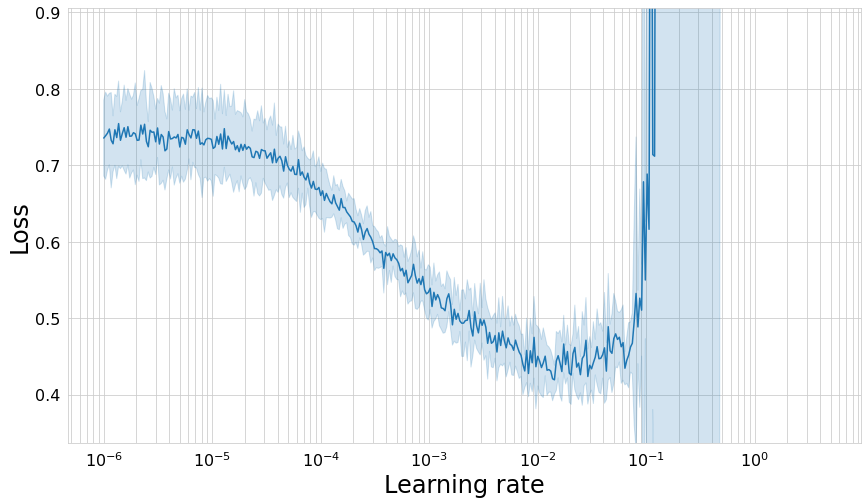

In [31]:
lr_finder = lr_find(train_fy, model_builder, bs, lr_bounds=[1e-6,1e0])

In [32]:
from lumin.nn.callbacks.cyclic_callbacks import *
from lumin.nn.metrics.class_eval import RocAucScore, BinaryAccuracy
from functools import partial

cb_partials = [partial(OneCycle, lengths=[5, 10],lr_range=[1e-4, 1e-2], mom_range=[0.85, 0.95], interp='cosine')]
metric_partials = [RocAucScore, BinaryAccuracy]

In [33]:
from lumin.nn.training.train import train_models

Training model 1 / 1, Valid Index = 0, Train indices= [1, 2, 3, 4, 5, 6, 7, 8, 9]


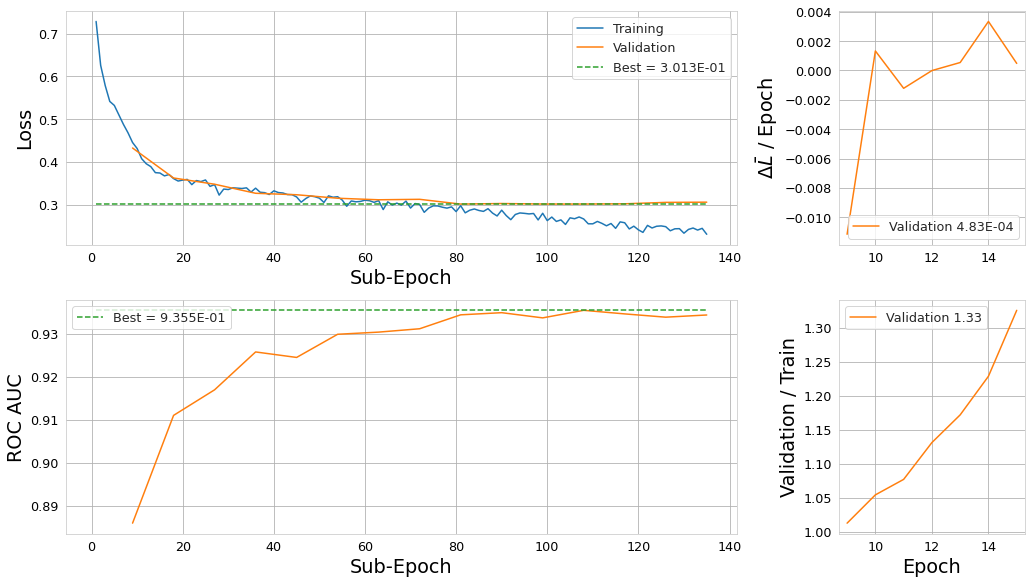

Loading best model with metric value -9.355E-01
Model took 36.028s

Scores are: {'loss': 0.30141615867614746, 'ROC AUC': 0.9355086587255416, 'Acc': 0.8798}

______________________________________
Training finished
Cross-validation took 36.100s 


<Figure size 1024x576 with 0 Axes>

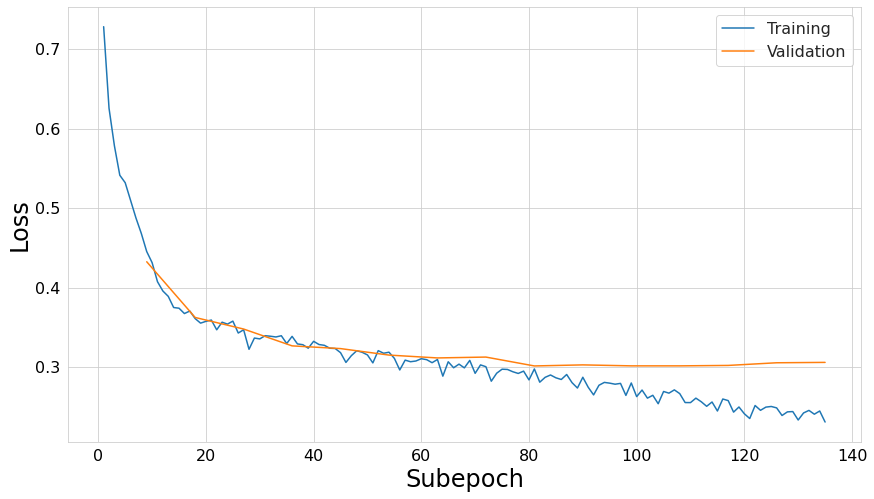

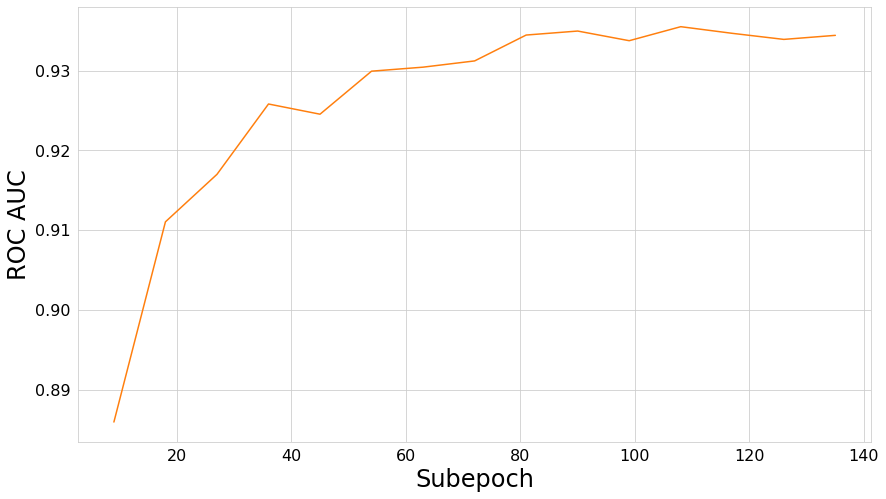

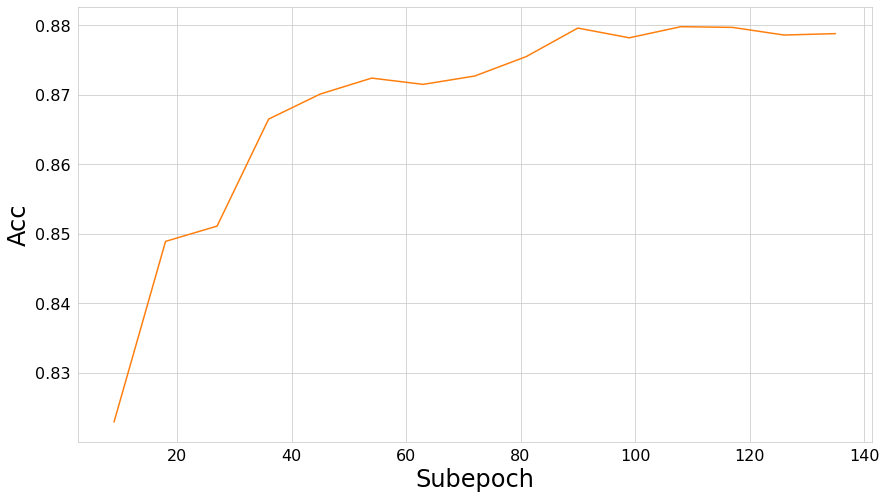

Mean loss = 0.30141615867614746±0.0
Mean ROC AUC = 0.9355086587255416±0.0
Mean Acc = 0.8798±0.0
______________________________________



In [34]:
_ = train_models(train_fy, n_models=1,
                 model_builder=model_builder,
                 bs=bs,
                 cb_partials=cb_partials,
                 metric_partials=metric_partials,
                 n_epochs=15)

Our DNN achieves a validation AUC of 0.936

## Gravitational Net
We'll construct a graph for each jet by using the sub-jets as nodes, and their 4-momenta as features per node. Our data is still a flat table of features per jet, but it can automatically be reshaped into a tensor of (batch x node x feature) by defining what prefixes to consider as nodes (vectors) and what suffixes consider as features per node.

E.g. given a feature name of "0_px", "0" should be considered as a node identifier, and "px" should considered as a feature of the "0" node.

Note, the flat data will be reshaped during the forward pass, however we could have saved the data already processed into the (batch x node x feature) tensor.

In [35]:
from lumin.data_processing.hep_proc import get_vecs

fpv = ['px', 'py', 'pz', 'e']
vecs = [str(i) for i in sorted([int(f) for f in get_vecs(train_fy.cont_feats)])]
fpv, vecs

(['px', 'py', 'pz', 'e'],
 ['0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '10',
  '11',
  '12',
  '13',
  '14'])

GNNs in LUMIN consist of two parts:
- extractor: GNN layers used to compute new features per node
- collapser: aggregates/flattens node features into flat vector. Can also apply a few fully connected layers to nodes prior to collapsing

`GNNHead` class wraps the extractor and collapser in a single object. Forward method:
```python
def forward(self, x:Union[Tensor,Tuple[Tensor,Tensor]]) -> Tensor:
    r'''
    Passes input through the GravNet head and returns a flat tensor.

    Arguments:
        x: If a tuple, the second element is assumed to the be the matrix data. If a flat tensor, will convert the data to a matrix

    Returns:
        Resulting tensor
    '''

    x = self._process_input(x)  # features per vtx per datapoint
    if self.use_in_bn: x = self.bn(x)
    if self.cat_means:
        if self.row_wise: x = torch.cat([x,x.mean(1).unsqueeze(2).repeat_interleave(repeats=x.shape[1],dim=2).transpose(1,2)],dim=2)
        else:             x = torch.cat([x,x.mean(2).unsqueeze(1).repeat_interleave(repeats=x.shape[2],dim=1).transpose(1,2)],dim=1)
    x = self.extractor(x)  # new features per vtx per datapoint
    if not self.row_wise: x = x.transpose(1,2)
    x = self.collapser(x)  # features per datapoint
    return x
```

In [36]:
from lumin.nn.models.blocks.head import GNNHead

GravNet layers can be stacked together. `GravNet` class passes node features through a set number of layers, and concatenates the output of each one to the initial node features. Forward method
```python
def forward(self, x:Tensor) -> Tensor:
    r'''
    Passes input through the GravNet head.

    Arguments:
        x: row-wise tensor (batch x vertices x features)

    Returns:
        Resulting tensor row-wise tensor (batch x vertices x new features)
    '''

    outs = [x]
    for l in self.grav_layers: outs.append(l(outs[-1]))
    return torch.cat(outs[1:], dim=-1)
```



Each layer is a `GravNetLayer` class. Breaking down the forwards pass step by step:
```python
def forward(self, x:Tensor) -> Tensor:
    r'''
    Pass batch of vertices through GravNet layer and return new features per vertex

    Arguments:
        x: Incoming data (batch x vertices x features)

    Returns:
        Data with new features per vertex (batch x vertices x new features)
    '''

    # Concat means
    if self.cat_means:
        x = torch.cat([x,x.mean(1).unsqueeze(2).repeat_interleave(repeats=x.shape[1],dim=-1).transpose(1,2)],dim=2)
```
The features per node can be optionally extended to include the mean values of each feature across the graph.
```python
    # Compute spatial and vertex features
    slr = self.f_slr(x)
    s,lr = slr[:,:,:self.n_s],slr[:,:,self.n_s:]
```
An initial DNN `f_slr` is used to compute: `s` spatial coordinates, and `lr` features per node. In PyTorch, DNNs automatically broadcast across all tensor dimensions except the last one, so `f_slr(x)` applies the same DNN to every node in every graph in the batch.
```python
    # kNN
    d_jk = torch.norm(s[:,:,None]-s[:,None], dim=-1)
    idxs = self._knn(d_jk)
```
For every node, compute the Euclidean distance between it and all nodes in the same graph (including itself) using `s` as coordinates in latent space. For every node, select the *k* nearest neighbours (including itself). *N.B.* "for" is used here to describe the process, but the above lines are vectorised and compute all distances in a single function.
```python
    def _knn(self, dists:Tensor) -> Tuple[Tensor,Tensor,Tensor]:
        idxs = dists.argsort()
        i = np.arange(dists.shape[0])[:,None,None]
        j = np.arange(dists.shape[1])[None,:,None]
        return i,j,idxs[:,:,:self.k]
```
This just orders the distances, and returns indices to look up the *k* nearest neighbours.
```python
    d_jk = d_jk[idxs] 
    lr = lr[:,None].expand(lr.shape[0],lr.shape[1],lr.shape[1],lr.shape[2])[idxs]
```
The distances `d_jk` are already a (batch x node x node) tensor, and are indexed to return a (batch x node x *k*-nearest nodes) tensor.  The `lr` features are expanded and indexed into a (batch x node x *k*-nearest nodes x features).
```python
    v_jk = self.potential(d_jk)
    ft_ijk = lr*v_jk.unsqueeze(-1)
    if self.use_sa: ft_ijk = self.sa_agg(ft_ijk)
```
The `d_jk` distances are used to weight feature through a potential function, e.g. `torch.exp(-10*(d_jk**2)`. I.e. close-by nodes' features have a higher weight than those of more distance nodes. Optionally, and unique to LUMIN, [self-attention](https://arxiv.org/abs/1706.03762) can be used to here to also provide a learnable feature weighting (still experimental, and sometimes reduces performance).
```python
    fp = [x]
    for agg in self.agg_methods: fp.append(agg(ft_ijk))
    fp = torch.cat(fp,dim=-1)
```
Neighbourhhood features are constructed by aggregating the distance-weighted features of the *k* nearest nodes, e.g. taking the mean and maximum. These are then concatenated with the original features of the node.
```python
    # Output
    return self.f_out(fp)
```
Finally, the output features per node per graph are computed using a second DNN based on the node features + the neighbourhood features.

In [37]:
from lumin.nn.models.blocks.gnn_blocks import  GravNet

Finally, we pass the (batch x node x features) tensor through the `GraphCollapser` to transform it into a (batch x feature) tensor:
```python
def forward(self, x:Tensor) -> Tensor:
    r'''
    Collapses features per vertex down to features

    Arguemnts:
        x: incoming data (batch x vertices x features)

    Returns:
        Flattened data (batch x flat features)
    '''
    if self.global_feat_vec and self.gfv_pos == 'pre-initial':
        x = torch.cat([x,x.mean(1).unsqueeze(2).repeat_interleave(repeats=x.shape[1],dim=2).transpose(1,2)],dim=2) 
    x = self.f_inital(x)
    if self.n_sa_layers > 0:
        outs = []
        for i, sa in enumerate(self.sa_layers): outs.append(sa(outs[-1] if i > 0 else x))
        x = torch.cat(outs, dim=-1)
    if self.global_feat_vec and self.gfv_pos == 'pre-final':
        x = torch.cat([x,x.mean(1).unsqueeze(2).repeat_interleave(repeats=x.shape[1],dim=2).transpose(1,2)],dim=2)
    x = self.f_final(x)
    return self._agg(x)
```
This is quite configurable:
- DNNs (`f_inital` and `f_final`) can be used to reduce the number of features per node per graph and two different stages (or they can be `lambda x: x`).
- A "global feature vertex" can be computed, which concatenates the mean values of features across all nodes per graph (like the `cat_means` in the gravnet layers). This can be done before either of the two DNNs.
- Multiple self-attention blocks can be used to augment the features, a la [point-cloud transformer](https://link.springer.com/article/10.1007/s41095-021-0229-5) (see also [Point Cloud Transformers applied to Collider Physics](https://iopscience.iop.org/article/10.1088/2632-2153/ac07f6))
- Finally the tensor is either reshaped or aggregated:
```python
def _agg(self, x:Tensor) -> Tensor:
    if self.flatten: return x.reshape((len(x),-1))
    else:            return torch.cat([agg(x) for agg in self.agg_methods],-1)
```
where `agg_methods` are the mean and maximum of the features across the nodes.

In [38]:
from lumin.nn.models.blocks.gnn_blocks import  GravNet, GraphCollapser

head = partial(GNNHead, vecs=vecs, feats_per_vec=fpv,
               extractor=partial(GravNet,  # Use GravNet for feature extraction
                                 cat_means=True,  # Concatenate the means of features as new features
                                 f_slr_depth=3,  # Use 3 hidden layers to compute the coordinates and features in latent space
                                 n_s=4,  # Use 4 dimensions for latent space
                                 n_lr=22,  # Compute 22 features per vertex for the latent representation
                                 k=10,  # Each vertex should consider the 10 nearest vertices (self included) when computing neighbourhood features
                                 f_out_depth=1,  # Use one hidden layer to compute the new features per vertex
                                 n_out=[48,48,48,48],  # Use 4 GravNet layers, each computing 48 new features per vertex
                                 act='swish'),  # Use swish activation functions
               collapser=partial(GraphCollapser,  # Use default graph collapser
                                 flatten=True,  # Reshape the data into (batch x features) without aggregation. Vertices are ordered by pT
                                 f_final_outs=[40],  # Compute 40 features per vertex based on the GravNet layer outputs
                                 act='swish'))  # Use swish activation functions
model_builder = get_model_builder(train_fy, depth=3, width=50, head=head)

Inputs:
60 Continuous: ['0_e', '0_px', '0_py', '0_pz', '1_e', '1_px', '1_py', '1_pz', '2_e', '2_px', '2_py', '2_pz', '3_e', '3_px', '3_py', '3_pz', '4_e', '4_px', '4_py', '4_pz', '5_e', '5_px', '5_py', '5_pz', '6_e', '6_px', '6_py', '6_pz', '7_e', '7_px', '7_py', '7_pz', '8_e', '8_px', '8_py', '8_pz', '9_e', '9_px', '9_py', '9_pz', '10_e', '10_px', '10_py', '10_pz', '11_e', '11_px', '11_py', '11_pz', '12_e', '12_px', '12_py', '12_pz', '13_e', '13_px', '13_py', '13_pz', '14_e', '14_px', '14_py', '14_pz']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): GNNHead(
    (extractor): GravNet(
      (grav_layers): ModuleList(
        (0): GravNetLayer(
          (f_slr): Sequential(
            (0): Sequential(
              (0): Linear(in_features=8, out_features=30, bias=True)
              (1): Swish()
            )
            (1): Sequential(
              (0): Linear(in_feat

LR finder took 70.725s 


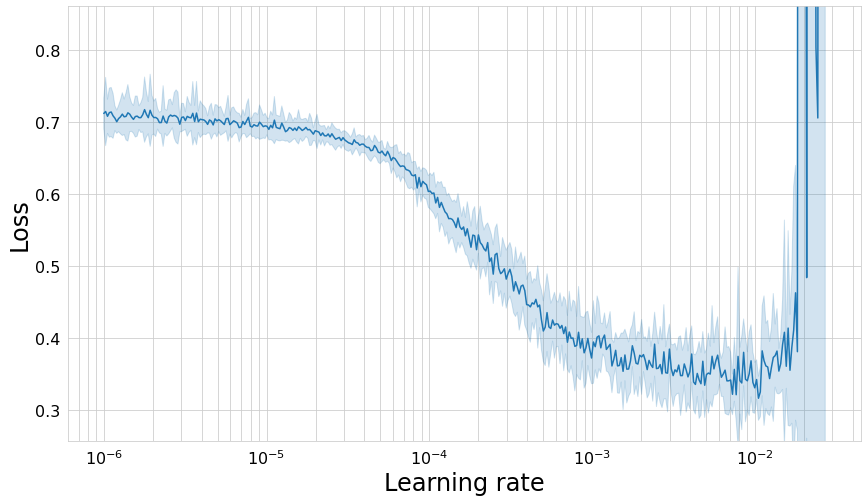

In [39]:
lr_finder = lr_find(train_fy, model_builder, bs, lr_bounds=[1e-6,1e-2])

In [40]:
cb_partials[0].keywords['lr_range'] = [1e-4, 1e-2]

Training model 1 / 1, Valid Index = 0, Train indices= [1, 2, 3, 4, 5, 6, 7, 8, 9]


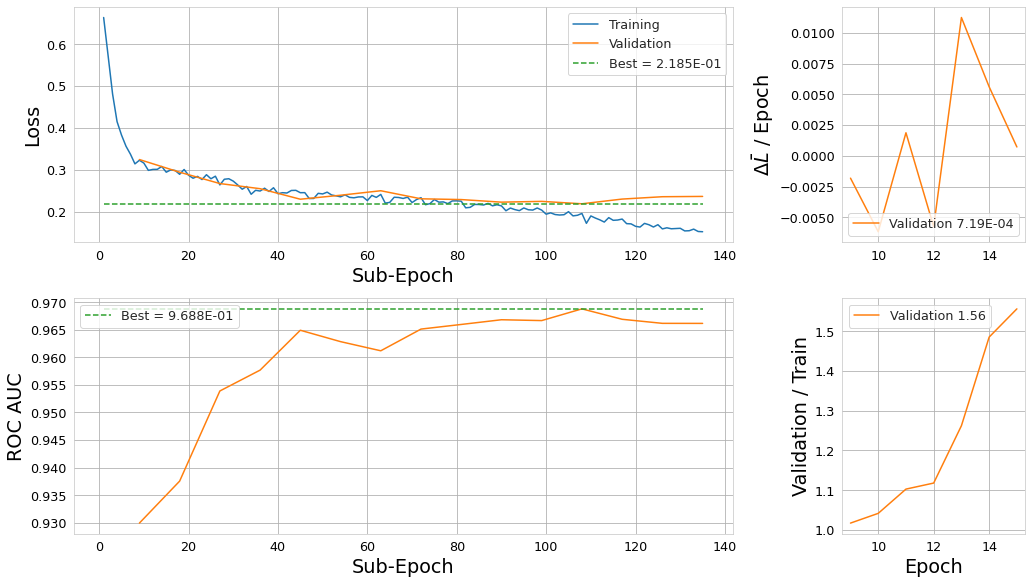

Loading best model with metric value -9.688E-01
Model took 119.075s

Scores are: {'loss': 0.21845224499702454, 'ROC AUC': 0.9687919000268159, 'Acc': 0.9135}

______________________________________
Training finished
Cross-validation took 119.161s 


<Figure size 1024x576 with 0 Axes>

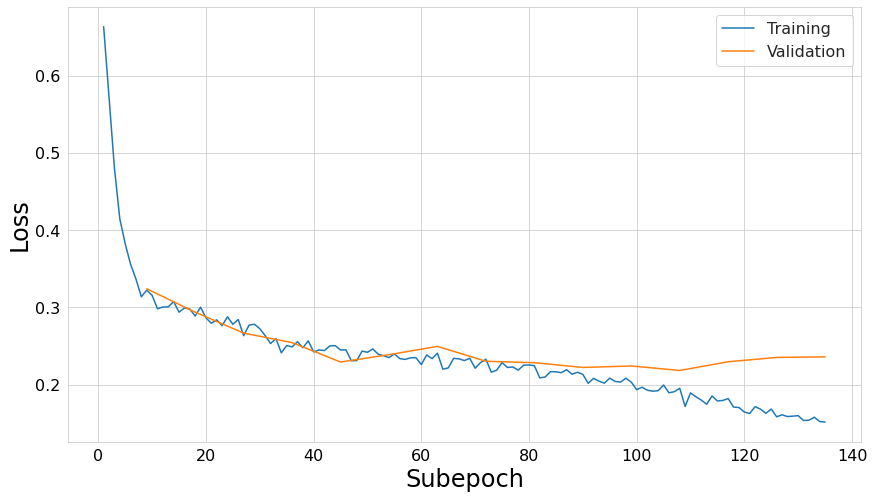

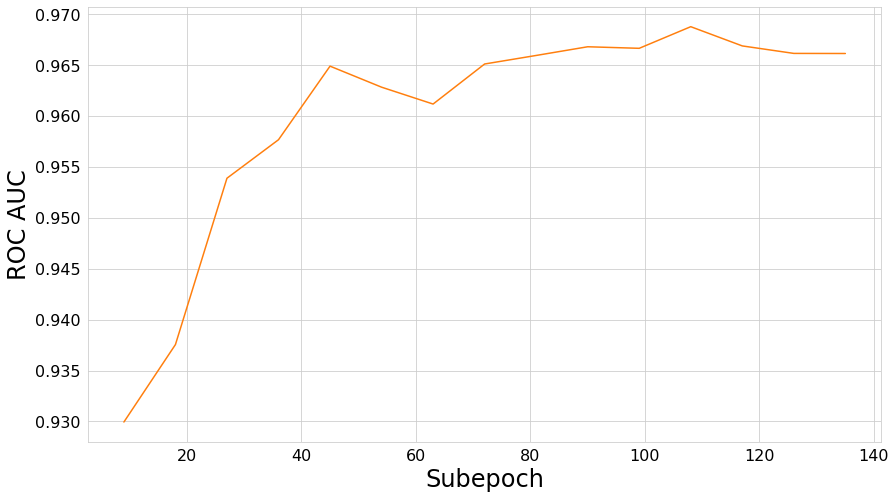

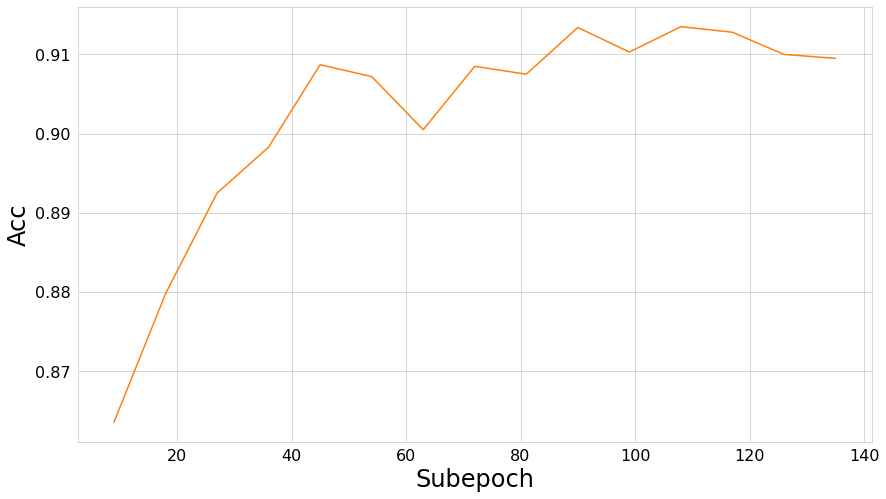

Mean loss = 0.21845224499702454±0.0
Mean ROC AUC = 0.9687919000268159±0.0
Mean Acc = 0.9135±0.0
______________________________________



In [41]:
_ = train_models(train_fy, n_models=1,
                 model_builder=model_builder,
                 bs=bs,
                 cb_partials=cb_partials,
                 metric_partials=metric_partials,
                 n_epochs=15)

An AUC of 0.969, which is a large improvement over the baseline.